In [1]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from PIL import Image

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms
from torchvision.transforms import functional as TVF
from torchvision import models

from dataclasses import dataclass

In [4]:
import collections

# Data Class 
Defined Data class members

In [5]:
# Data contants
@dataclass
class DataConfiguration:
    data_root: str = '/kaggle/input/pytorch-opencv-course-classification/'
    images_data: str = 'images/images'
    output_data: str = '/kaggle/working'
    train_file_name: str = 'train.csv'
    test_file_name: str = 'test.csv'    
    submission_file_name: str = 'submission.csv'
    split_ratio:int = 0.8
    model_dir:str = 'models'
    model_file_name:str = 'kenya_food_classifier.pt'
    tensorboard_log_dir = 'tensorboard_kenya_food_classifier'

In [6]:
data_config = DataConfiguration()

In [7]:
def get_tensorboard_log_path(parent_dir, tensorboard_log_dir):
    log_path = os.path.join(parent_dir, tensorboard_log_dir)
    if not os.path.exists(log_path):
        os.chdir(parent_dir)
        os.makedirs(tensorboard_log_dir)
        
    return log_path

In [8]:

%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir = '/kaggle/working/tensor_logs'

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2020-06-16 09:03:48.429757: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure

# 0 General Functions

The following section contains general functions

## 0.1 Device Type

Get the Device running type

In [9]:
#Check whether the running system is GPU/CPU
def GetDeviecType():
    if torch.cuda.is_available():
        device = "GPU"
    else:
        device = "CPU"
    return device

In [10]:
target_device = GetDeviecType()
print (f'The running device is {target_device}.')

The running device is GPU.


## 0.2 Get the Labels

Get the Labels of the classifier from the training file

In [11]:
def GetLabels(data_root, train_file_name):
    # Get the training file including its path
    csv_path = os.path.join(data_root, train_file_name)
    
    #Read the CVS file using Panda
    csv_df = pd.read_csv(csv_path, delimiter =' *, *', engine ='python')
    #print(f'There are {csv_df.shape[0]} rows and {csv_df.shape[1]} columns in this data frame')
    
    #Get the Unique class type which are Labels/classes
    classes = csv_df['class'].unique().tolist()
    
    return classes                                         

In [12]:
labels =  GetLabels(data_config.data_root, data_config.train_file_name)
print(labels)

['githeri', 'ugali', 'kachumbari', 'matoke', 'sukumawiki', 'bhaji', 'mandazi', 'kukuchoma', 'nyamachoma', 'pilau', 'chapati', 'masalachips', 'mukimo']


# 1. Data Loader
Data is divided into into train and validation data, 80:20 ratio for train and validation, respectively.

In [13]:
class KenyanFood13Dataset(Dataset):
    """
    This custom dataset class take root directory.
    Returns train and validation data loader.
    """
            
    def __init__(self, data_root, train_file_name, images_data, transform, train = True, split_ratio = 0.8):
        
        # Get the train csv file, including the path
        csv_path = os.path.join(data_root, train_file_name)  
        #Read the Train data to Data Frame
        csv_df = pd.read_csv(csv_path, delimiter =' *, *', engine ='python')
                
        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }
        
        # set transform attribute
        self.transform = transform        
        self.target_transform = transform
        
                
        #split the data ratio into training and validation
        total_rows = csv_df.shape[0]
        start = 0
        end = 0
        
        if (train):
            start = int(total_rows * (1 - split_ratio))
            end = total_rows
        else:
            start = 0
            end = int(total_rows * (1 - split_ratio))
        
        #Get the images path 
        images_path = os.path.join(data_root, images_data)        
        
        #For each entry in the csv file, prepare the image file and the corresponding clas label
        for index in range(start, end):            
            img_file_name = os.path.join(images_path, str(csv_df['id'][index]))
            img_file_name += '.jpg'            
            label_index = labels.index(csv_df['class'][index])            
            self.data_dict['image_path'].append(img_file_name)
            self.data_dict['label'].append(label_index)         
      
    def __len__(self):
        """
        return length of the dataset.
        """
        return len(self.data_dict['label'])
        
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing and the class label.
        """
        
        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")                 
        
        if self.transform is not None:
            image = self.transform(image)
            
        target = self.data_dict['label'][idx]

        return image, target  
    
    def GetClasses(self):
        return self.data_dict['label']

https://pytorch.org/hub/pytorch_vision_resnext/ to get mean and std.

In [14]:
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

In [15]:
def validate_test_transforms():    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])
    
    return transform

In [16]:
def train_transforms():
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),        
        transforms.RandomRotation(20),
        transforms.ColorJitter(0.3, 0.3, 0.3),        
        transforms.ToTensor(),
        transforms.Normalize(mean, std)        
        ])  
    
    return transform

In [17]:
def display_transforms():    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()        
        ])
    
    return transform

In [18]:
validate_test_transform = validate_test_transforms()
train_transform = train_transforms()
display_transform = display_transforms()

In [19]:
#Get the Test Loader, testing purpose
def test_train_loader():            
    train_dataset =  KenyanFood13Dataset(data_config.data_root,
                                        data_config.train_file_name,
                                        data_config.images_data,                                        
                                        transform = display_transform)    
    
    print("Train Data Set Length = ", train_dataset.__len__())
    # dataloader with train dataset
    train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size = 8,
            shuffle = True,
            num_workers = 0
        )

    
    # Plot few images
    plt.rcParams["figure.figsize"] = (15, 9)
    plt.figure     
    
    #for images, targets in train_loader:
    for batch_idx, (images, targets) in enumerate(train_loader):        
        for i in range(len(targets)):
            plt.subplot(3, 5, i+1)
            img = TVF.to_pil_image(images[i])
            plt.imshow(img)
            plt.gca().set_title('Target: {0} : {1}'.format(targets[i],labels[targets[i]]))
        plt.show()
        break
        
#test_train_loader()

The number of validation samples are **1307**.

In [20]:
#Get the Train Weights
def get_weights(train = True, debug = False):    
    data_set = KenyanFood13Dataset(data_config.data_root,
                                   data_config.train_file_name,
                                   data_config.images_data,
                                   transform = display_transform,
                                   train = train)
    if (debug == True):
        if (train == True):
            print("Test Data Set ")
        else:
            print("Validation Data Set ")
            
    
    targets = data_set.GetClasses()
    targets_collections = collections.Counter(targets)
    
    if (debug == True):
        print('Number of Labels = {}'.format(len(targets)))
        print("No. classes = ", np.unique(targets))    
        print("Classes Frequency = ", targets_collections)
    
    target_weights = []
    
    for index in range(len(targets_collections)):
        target_weights.append(targets_collections[index])    
    
    target_weights = [index / max(target_weights) for index in target_weights]    
    torch_target_weights = torch.tensor(target_weights)      
        
    if (debug == True):
        print(target_weights)
        print('Maximum value = ', max(target_weights))
        print('Normalized Weights',torch_target_weights)
    
    return torch_target_weights	

In [21]:
train_weights = get_weights(train = True, debug = True)
validation_weights = get_weights(train = False, debug = True)

Test Data Set 
Number of Labels = 5229
No. classes =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Classes Frequency =  Counter({10: 708, 8: 633, 1: 506, 6: 505, 5: 492, 2: 403, 0: 385, 3: 383, 11: 344, 4: 313, 9: 258, 12: 167, 7: 132})
[0.5437853107344632, 0.7146892655367232, 0.5692090395480226, 0.5409604519774012, 0.442090395480226, 0.6949152542372882, 0.713276836158192, 0.1864406779661017, 0.8940677966101694, 0.3644067796610169, 1.0, 0.4858757062146893, 0.23587570621468926]
Maximum value =  1.0
Normalized Weights tensor([0.5438, 0.7147, 0.5692, 0.5410, 0.4421, 0.6949, 0.7133, 0.1864, 0.8941,
        0.3644, 1.0000, 0.4859, 0.2359])
Validation Data Set 
Number of Labels = 1307
No. classes =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Classes Frequency =  Counter({10: 154, 8: 151, 5: 140, 1: 122, 6: 115, 3: 100, 0: 94, 11: 94, 2: 91, 4: 89, 9: 71, 12: 45, 7: 41})
[0.6103896103896104, 0.7922077922077922, 0.5909090909090909, 0.6493506493506493, 0.577922077922078, 0.9090909090909091, 0.7467532

In [22]:
#Testing the ratio of Train and validation Data Set
train_dataset = KenyanFood13Dataset(data_config.data_root,
                                        data_config.train_file_name,
                                        data_config.images_data,                                        
                                        transform = display_transform,
                                        train = True)
print('Length of Train Data Set = ', len(train_dataset))

validation_dataset = KenyanFood13Dataset(data_config.data_root,
                                        data_config.train_file_name,
                                        data_config.images_data,                                        
                                        transform = display_transform,
                                        train = False)
print('Length of Train Data Set = ', len(validation_dataset))

Length of Train Data Set =  5229
Length of Train Data Set =  1307


In [23]:
def data_loader(data_root, 
                train_file_name,
                images_data,
                transform,
                train,                
                batch_size = 16,
                shuffle = False,
                num_workers = 2):
    
    dataset = KenyanFood13Dataset(data_root, train_file_name, images_data, transform, train = train)
    
    loader = torch.utils.data.DataLoader(dataset,
                                             batch_size = batch_size,
                                             num_workers = num_workers,
                                             shuffle = shuffle)
                                             
    
    return loader

In [24]:
  def get_data(data_root, train_file_name, images_data, batch_size, num_workers = 4, data_augmentation = False):
    
    # train dataloader    
    train_loader = data_loader(data_root,
                               train_file_name,
                               images_data,                               
                               transform = train_transform, 
                               train = True,
                               batch_size = batch_size, 
                               shuffle = True, 
                               num_workers = num_workers)
    
    # validation dataloader    
    validation_loader = data_loader(data_root,
                              train_file_name,
                              images_data,                              
                              transform = validate_test_transform, 
                              train = False,
                              batch_size = batch_size, 
                              shuffle = True, 
                              num_workers = num_workers)
    
    return train_loader, validation_loader


# 2. System Configuration


In [25]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 8 
    epochs_count: int = 10 
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    decay_rate:float =  0.1        
    log_interval: int = 5  
    test_interval: int = 1    
    num_workers: int = 4 
    device: str = 'cuda'

In [26]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [27]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [28]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int, tb_writer: SummaryWriter
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
     
    train_weights = get_weights(True)    
    train_weights = train_weights.to(train_config.device)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        #loss = F.cross_entropy(output, target)
        
        criterion = nn.CrossEntropyLoss(weight = train_weights)
        loss = criterion(output, target)
        
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
        
        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:            
            total_batch = epoch_idx * len(train_loader.dataset) / train_config.batch_size + batch_idx
            tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
            tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    
    return epoch_loss, epoch_acc

In [29]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    
    validation_weights = get_weights(False)
    validation_weights = validation_weights.to(train_config.device)
        
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        
                
        #test_loss += F.cross_entropy(output, target).item()
        validation_weights = validation_weights.to(train_config.device)
        criterion = nn.CrossEntropyLoss(weight = validation_weights)
        test_loss += criterion(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.
          format(test_loss, count_corect_predictions, len(test_loader.dataset), accuracy))
    
    return test_loss, accuracy/100.0

In [30]:
def save_model(model, device, parent_dir, model_dir = 'models', model_file_name ='kenya_food_classifier.pt'):
    
    data_path = os.path.join(parent_dir, model_dir) 
    if not os.path.exists(data_path):
        os.chdir(parent_dir)
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)
    #print("Model Path =", model_path)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

In [31]:
def load_model(model, parent_dir, model_dir = 'models', model_file_name = 'kenya_food_classifier.pt'):
    model_path = os.path.join(parent_dir, model_dir, model_file_name)
    print('Model Path =', model_path)
    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

In [32]:
def main(model, optimizer, tb_writer, scheduler = None, system_configuration = SystemConfiguration(), 
         training_configuration = TrainingConfiguration(), 
         data_configuration = DataConfiguration(), data_augmentation = True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size = batch_size_to_set,
        data_root = data_configuration.data_root,
        train_file_name = data_configuration.train_file_name,
        images_data = data_configuration.images_data,
        num_workers = num_workers_to_set,
        data_augmentation = data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
#         Calculate Initial Test Loss
        #init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
        #print("Initial Test Loss : {:.6f}, Initial Test Accuracy : {:.3f}%".format(init_val_loss, init_val_accuracy*100))
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch, tb_writer)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])
        
        # add scalar (loss/accuracy) to tensorboard
        tb_writer.add_scalar('Loss/Train',train_loss, epoch)
        tb_writer.add_scalar('Accuracy/Train', train_acc, epoch)

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print("Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta))
        
        # add time metadata to tensorboard
        tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
        tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
        tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
        tb_writer.add_scalar('Time/eta', eta, epoch)

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            # add scalar (loss/accuracy) to tensorboard
            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)
            
            # add scalars (loss/accuracy) to tensorboard
            tb_writer.add_scalars('Loss/train-val', {'train': train_loss, 
                                           'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc, 
                                               'validation': current_accuracy}, epoch)
            
            if current_loss < best_loss:
                best_loss = current_loss                
                save_model(model, device = training_configuration.device, 
                           parent_dir = data_configuration.output_data)
                print('Model Improved. Saved the Model...')
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [33]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

In [34]:
def pretrained_resnext(transfer_learning = True, num_class = 13):
    resnet = models.resnext101_32x8d(pretrained = True)
    
    '''for name, child in resnet.named_children():
        print(name)
        
    for name, child in resnet.named_children():
        if name in ['layer4']:
            print(name + ' has been unfrozen.')
            for param in child.parameters():
                param.requires_grad = True
        else:
            for param in child.parameters():
                param.requires_grad = False    
    '''
            
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Linear(last_layer_in, num_class)
    
    return resnet
    

In [35]:
model = pretrained_resnext(transfer_learning=True)
#print(model)

# get optimizer
train_config = TrainingConfiguration()

# optimizer


optimizer = optim.SGD(
    model.parameters(),
    lr = train_config.init_learning_rate,
    momentum = 0.9
)

decay_rate = train_config.decay_rate

lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

# Scheduler
#scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)


# Tensorboard summary writer
log_sw = SummaryWriter('/kaggle/working/tensor_logs/resnext101_32x8d')   

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [36]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, log_sw, scheduler = scheduler, data_augmentation = True)

Epoch: 0 
Train Loss: 1.830625 Acc: 0.3500
Elapsed 267.53s, 267.53 s/epoch, 0.41 s/batch, ets 2407.77s
Test set: Average loss: 1.3246, Accuracy: 718/1307 (55%)
Model Improved. Saved the Model...
Epoch: 1 
Train Loss: 1.346173 Acc: 0.5242
Elapsed 589.56s, 294.78 s/epoch, 0.45 s/batch, ets 2358.23s
Test set: Average loss: 1.0349, Accuracy: 850/1307 (65%)
Model Improved. Saved the Model...
Epoch: 2 
Train Loss: 1.169249 Acc: 0.5835
Elapsed 911.35s, 303.78 s/epoch, 0.46 s/batch, ets 2126.48s
Test set: Average loss: 0.9001, Accuracy: 900/1307 (69%)
Model Improved. Saved the Model...
Epoch: 3 
Train Loss: 1.066778 Acc: 0.6127
Elapsed 1232.18s, 308.04 s/epoch, 0.47 s/batch, ets 1848.26s
Test set: Average loss: 0.8634, Accuracy: 913/1307 (70%)
Model Improved. Saved the Model...
Epoch: 4 
Train Loss: 0.982025 Acc: 0.6430
Elapsed 1553.39s, 310.68 s/epoch, 0.48 s/batch, ets 1553.39s
Test set: Average loss: 0.8148, Accuracy: 934/1307 (71%)
Model Improved. Saved the Model...
Epoch: 5 
Train Loss: 0

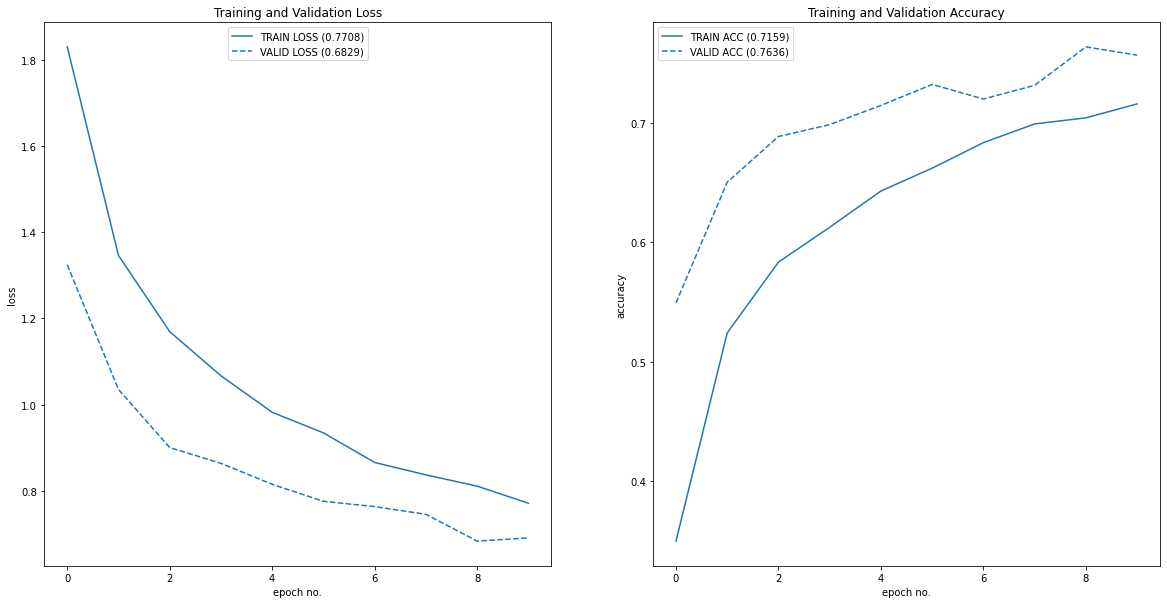

In [37]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

In [38]:
class KenyanFood13Testset(Dataset):
    """
    This custom dataset class take root directory.    
    """
    
    def __init__(self, data_root, test_file_name, images_data, transform):
    
        # Get the test csv file, including the path
        csv_path = os.path.join(data_root, test_file_name)  
        #Read the Train data to Data Frame
        csv_df = pd.read_csv(csv_path, delimiter =' *, *', engine ='python')
        #print(csv_df)        
        #print(f'There are {csv_df.shape[0]} rows and {csv_df.shape[1]} columns in this data frame')
        #csv_df.info()
                        
       # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': [] 
        }
 
        # set transform attribute
        self.transform = transform
        
        #Get the images path 
        images_path = os.path.join(data_root, images_data)        
 
        for index in range (csv_df.shape[0]):
            img_file_name = os.path.join(images_path, str(csv_df['id'][index]))
            img_file_name += '.jpg'  
            self.data_dict['image_path'].append(img_file_name)
            self.data_dict['label'].append(0)
            
    def __len__(self):
        """
        return length of the dataset.
        """
        return len(self.data_dict['label'])

    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing and the class label.
        """

        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")        
        image = self.transform(image)            
        target = self.data_dict['label'][idx]

        return image, target  


In [39]:
def prediction(model, device, batch_input,  max_prob = True):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    if max_prob:
        # get the max probability
        pred_prob = prob.data.max(dim=1)[0]
    else:
        pred_prob = prob.data
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [40]:
def get_target_and_prob(model, dataloader, device):
    """
    get targets and prediction probabilities
    """
    
    pred_prob = []
    pred_targets = []
    
    for _, (data, target) in enumerate(dataloader):
        
        pre_target, prob = prediction(model, device, data, max_prob = False)
        #print(pre_target)
        pred_prob.append(prob)                
        pred_targets.append(pre_target)
        
    pred_targets = np.concatenate(pred_targets)    
    pred_prob = np.concatenate(pred_prob, axis=0)
    
    return pred_targets, pred_prob

In [41]:
def get_test_predictions():
    data_config = DataConfiguration()
    preprocess =  validate_test_transform   
    
    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
    test_dataset =  KenyanFood13Testset(data_config.data_root, data_config.test_file_name, data_config.images_data, preprocess)
    print("Test Data Set Length = ", test_dataset.__len__())
    # dataloader with dataset
    test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size = 16,
            shuffle = False,
            num_workers = 2
        )
    
    model = pretrained_resnext(transfer_learning = True)
    model = load_model(model, parent_dir = data_config.output_data)
    pred_targets, pred_prob = get_target_and_prob(model, test_loader, device)
    
    return pred_targets, pred_prob

In [42]:
pred_targets, pred_prob = get_test_predictions()
print('No. of Predictions = ', len(pred_targets))

Test Data Set Length =  1638
Model Path = /kaggle/working/models/kenya_food_classifier.pt
No. of Predictions =  1638


In [43]:
def generate_submission(data_root, test_file_name, working_root, submission_file_name, targets, labels):
    test_path = os.path.join(data_root, test_file_name)
    test_data_df = pd.read_csv(test_path, delimiter =' *, *', engine ='python')
    
    
    ids = []
    classes = []
    if (test_data_df.shape[0] == len(targets)):
        for index in range (test_data_df.shape[0]):
            image_id = test_data_df['id'][index]
            ids.append(image_id)
            classes.append(labels[targets[index]])
    
        
    # dictionary of lists  
    dict = {'id': ids, 'class': classes}
    
    submission_data_df = pd.DataFrame(dict)
    
    submission_path = os.path.join(working_root, submission_file_name)
    submission_data_df.to_csv(submission_path, index = False)    
    

In [44]:
data_config = DataConfiguration()
generate_submission(data_config.data_root, data_config.test_file_name, data_config.output_data, data_config.submission_file_name, pred_targets, labels)

In [51]:
%tensorboard --logdir /kaggle/working/tensor_logs/

In [55]:
%tensorboard dev upload --logdir /kaggle/working/tensor_logs/

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2020-06-16 10:03:41.981434: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: Yes

Kaggle link
https://www.kaggle.com/premchedella/project-2

# Lessons Learned

* resnext50_32x4d 
    * Unfreezed Layer 4 did not give promising results
* resnext101_32x8d
    * Unfreezed Layer 4 did not give promising results
    * Training all layers with taking first 20% for validation and remaining 80% for training gives an 75.4% accuracy on test set.
* Heavy augmentation
    * Added Randmon Vertical, Random Affine, and Random Erasing -- For 20 ephocs, results to 75.33%
    * Removed Random Vertical, Random Affine, and Random Erasing -- For 20, epochs, results to 74.2%
    
* Weighted Cross Entropy
    * Test Accuracy is 79.1% , validation accuracy is 76.8%,and test accuracy is 
